In [1]:
import npaths
import numpy as np
import pickle
from math import pi

In [2]:
with open('power.pkl', 'rb') as f:
    power = pickle.load(f)

In [3]:
# calc assembly geom
Dfuel  = 0.950/100
Dguide = 1.224/100
pitch  = 1.26/100
nf     = 264
ng     = 25
Pfuel  = pi*Dfuel 
Pguide = pi*Dguide
Afuel  = pitch**2 - pi/4*(Dfuel**2) 
Aguide = pitch**2 - pi/4*(Dguide**2)
Af     = nf*Afuel + ng*Aguide
Pw     = nf*Pfuel + ng*Pguide
hyD    = 4*Af/Pw

In [4]:
# specify power and gemetry at all locations within the core
hyD = np.array(31*[hyD])
Af  = np.array(31*[Af])
dz  = np.array(3*[21]+12*[20]+3*[21])/100

In [ ]:
# channel data is initialized with number of channels
channelData = npaths.channelData(31)
channelData.add(hyD=hyD,Af=Af)

In [ ]:
# axial data is initialized with number of axial layers
axialData = npaths.axialData(16)
axialData.add(dz=dz,)

In [ ]:
rodData = npaths.RodData()
rodData.add(name=)

In [ ]:
fuelRod  = npaths.RadialData(comp=['UO2','Helium','Zircaloy'], nLayer=[3,3,3], rOut=[0.4095,0.410,0.475])
guideRod = npaths.RadialData(comp=['Helium','Zircaloy']      , nLayer=[3,3,3], rOut=[0.547,0.612]       )

In [5]:
# initialize core 
core = npaths.MultiChannel(power,channelData,axialData,rodData)

In [6]:
# solve with sepcific inputs
mDot = 2325
pIn  = 15.6e+06
tIn  = 289.1+273.15
core.solve(mDot,pIn,tIn)

In [7]:
from matplotlib import pyplot as plt

In [14]:
temps = core.get('axial',(15,slice(None)),['t'],mode='array')

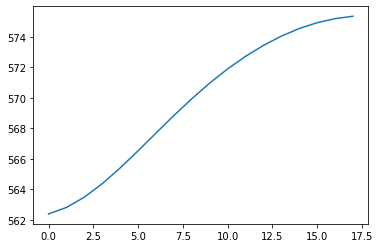

In [15]:
plt.plot(temps)